In [ ]:
import os, json, cv2, numpy as np

def coco_to_masks(coco_json, img_root, mask_root, prompt_text):
    os.makedirs(mask_root, exist_ok=True)
    with open(coco_json) as f:
        coco = json.load(f)

    image_info = {im['id']: im for im in coco['images']}

    for ann in coco['annotations']:
        im = image_info[ann['image_id']]
        h, w = im['height'], im['width']
        name = os.path.splitext(im['file_name'])[0]

        # create blank mask
        mask = np.zeros((h, w), dtype=np.uint8)

        # check if segmentation polygons exist
        if "segmentation" in ann and ann["segmentation"]:
            for seg in ann["segmentation"]:
                pts = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [pts], 255)
        else:
            # fallback to bbox if no polygon
            x, y, bw, bh = map(int, ann['bbox'])
            cv2.rectangle(mask, (x, y), (x + bw, y + bh), 255, -1)

        # save binary mask
        out_path = os.path.join(mask_root, f"{name}__{prompt_text}.png")
        cv2.imwrite(out_path, mask)

    print(f"✅ Masks saved in: {mask_root}")

# === Example usage ===
# coco_to_masks(
#     "cracks.v1i.coco/train/_annotations.coco.json",
#     "cracks.v1i.coco/train",
#     "cracks.v1i.coco/train/masks",
#     "segment_crack"
# )

# coco_to_masks(
#     "Drywall-Join-Detect.v2i.coco/train/_annotations.coco.json",
#     "Drywall-Join-Detect.v2i.coco/train",
#     "Drywall-Join-Detect.v2i.coco/train/masks",
#     "segment_taping_area"
# )


✅ Masks saved in: cracks.v1i.coco/train/masks


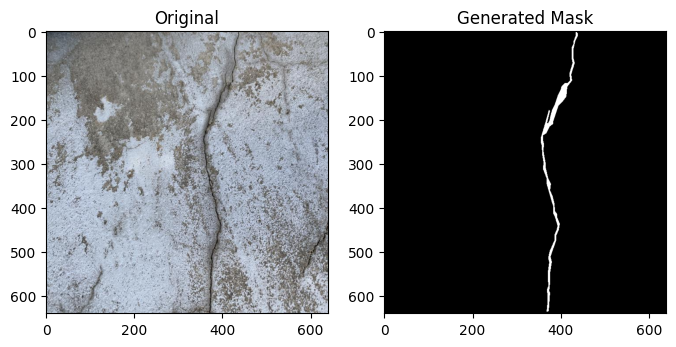

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import random

img_path = "cracks.v1i.coco/valid"
mask_path = os.path.join(img_path, "masks")

sample = random.choice([f for f in os.listdir(mask_path) if f.endswith(".png")])
orig = Image.open(os.path.join(img_path, sample.split("__")[0] + ".jpg")).convert("RGB")
mask = Image.open(os.path.join(mask_path, sample)).convert("L")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Generated Mask")
plt.show()


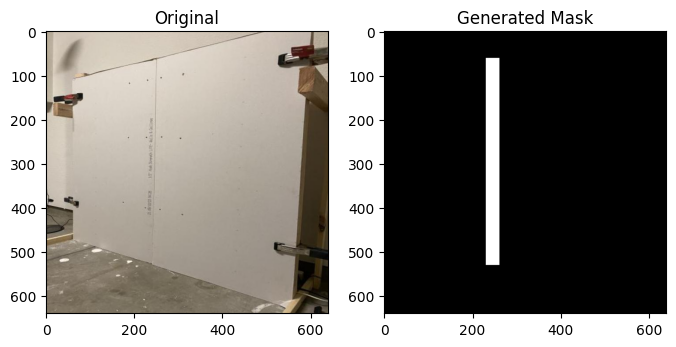

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import random

img_path = "Drywall-Join-Detect.v2i.coco/valid"
mask_path = os.path.join(img_path, "masks")

sample = random.choice([f for f in os.listdir(mask_path) if f.endswith(".png")])
orig = Image.open(os.path.join(img_path, sample.split("__")[0] + ".jpg")).convert("RGB")
mask = Image.open(os.path.join(mask_path, sample)).convert("L")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("Generated Mask")
plt.show()


In [3]:
!pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


In [8]:
!pip install torch torchvision transformers timm pillow matplotlib opencv-python


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 2.1/241.4 MB 10.7 MB/s eta 0:00:23
    --------------------------------------- 3.9/241.4 MB 9.4 MB/s eta 0:00:26
    --------------------------------------- 5.5/241.4 MB 9.3 MB/s eta 0:00:26
   - -------------------------------------- 7.1/241.4 MB 8.7 MB/s eta 0:00:27
   - -------------------------------------- 8.7/241.4 MB 8.7 MB/s eta 0:00:27
   - -------------------------------------- 10.5/241.4 MB 8.6 MB/s eta 0:00:27
   -- ------------------------------------- 12.3/241.4 MB 8.5 MB/s eta 0:00:28
   -- ------------------------------------- 14.2/241.4 MB 8.6 MB/s eta 0:00:27
   -- ------------------------------------- 16.0/241.4 MB 8.6 MB/s eta 0:00:27
   -- ------------------------------------- 17.8/241.4 MB 8.6 MB/s eta 0:00:26
   --- -----------

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PromptedSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, prompt):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.prompt = prompt

        # Only keep images with corresponding mask
        self.images = []
        for f in os.listdir(img_dir):
            if f.endswith((".jpg", ".png")):
                base = os.path.splitext(f)[0]
                mask_name = f"{base}__{prompt}.png"
                if os.path.exists(os.path.join(mask_dir, mask_name)):
                    self.images.append(f)

        print(f"✅ Dataset ready — {len(self.images)} samples in {img_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, f"{base}__{self.prompt}.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        return image, mask, self.prompt


In [2]:
# Crack dataset
crack_train = PromptedSegmentationDataset(
    "cracks.v1i.coco/train",
    "cracks.v1i.coco/train/masks",
    "segment_crack"
)
crack_valid = PromptedSegmentationDataset(
    "cracks.v1i.coco/valid",
    "cracks.v1i.coco/valid/masks",
    "segment_crack"
)

# Drywall dataset
dry_train = PromptedSegmentationDataset(
    "Drywall-Join-Detect.v2i.coco/train",
    "Drywall-Join-Detect.v2i.coco/train/masks",
    "segment_taping_area"
)
dry_valid = PromptedSegmentationDataset(
    "Drywall-Join-Detect.v2i.coco/valid",
    "Drywall-Join-Detect.v2i.coco/valid/masks",
    "segment_taping_area"
)


✅ Dataset ready — 5164 samples in cracks.v1i.coco/train
✅ Dataset ready — 201 samples in cracks.v1i.coco/valid
✅ Dataset ready — 818 samples in Drywall-Join-Detect.v2i.coco/train
✅ Dataset ready — 202 samples in Drywall-Join-Detect.v2i.coco/valid


In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

print(f"Using device: {device}")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda


In [4]:
from torch.utils.data import DataLoader
from torch.optim import AdamW

def collate_fn(batch):
    images, masks, prompts = zip(*batch)
    return list(images), list(masks), list(prompts)

# ✅ Add collate_fn=collate_fn for all DataLoaders
train_loader_crack = DataLoader(crack_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader_crack   = DataLoader(crack_valid, batch_size=1, collate_fn=collate_fn)

train_loader_dry = DataLoader(dry_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader_dry   = DataLoader(dry_valid, batch_size=1, collate_fn=collate_fn)
torch.backends.cudnn.benchmark = False  # reduce GPU stress
torch.backends.cudnn.deterministic = True

optimizer = AdamW(model.parameters(), lr=5e-5)


In [5]:
def compute_metrics(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).float()
    intersection = (pred_bin * true_mask).sum()
    union = pred_bin.sum() + true_mask.sum()
    dice = (2 * intersection) / (union + 1e-6)
    iou = intersection / (pred_bin + true_mask - pred_bin * true_mask + 1e-6).sum()
    return dice.item(), iou.item()


In [6]:
from tqdm import tqdm
import numpy as np

def train_one_epoch(model, loader, optimizer, processor, device):
    model.train()
    total_loss = 0.0
    progress = tqdm(loader)
    for images, masks, prompts in progress:
        inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to(device)
        masks_resized = torch.stack([
            torch.tensor(np.array(m.resize((352, 352))), dtype=torch.float32)
            for m in masks
        ]).to(device) / 255.0  # no unsqueeze


        outputs = model(**inputs, labels=masks_resized)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress.set_description(f"loss={loss.item():.4f}")
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, processor, device):
    model.eval()
    dice_scores, iou_scores = [], []
    for images, masks, prompts in loader:
        inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to(device)
        masks_resized = torch.stack([
            torch.tensor(np.array(m.resize((352,352))), dtype=torch.float32)
            for m in masks
        ]).unsqueeze(1).to(device) / 255.0
        outputs = model(**inputs)
        preds = torch.sigmoid(outputs.logits)
        for p, t in zip(preds, masks_resized):
            dice, iou = compute_metrics(p, t)
            dice_scores.append(dice)
            iou_scores.append(iou)
    return np.mean(dice_scores), np.mean(iou_scores)


In [11]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from torch.optim import AdamW
import torch
import numpy as np
from tqdm import tqdm

def train_and_eval(model_name, train_loader, val_loader, prompt, save_path,
                   num_epochs=10, patience=3, lr=5e-5):
    """
    Trains CLIPSeg for segmentation with early stopping.

    Args:
        model_name (str): Model checkpoint name.
        train_loader, val_loader: Dataloaders.
        prompt (str): Text prompt.
        save_path (str): Path to save best model.
        num_epochs (int): Max epochs.
        patience (int): Stop if no Dice improvement for these many epochs.
        lr (float): Learning rate.
    """
    processor = CLIPSegProcessor.from_pretrained(model_name)
    model = CLIPSegForImageSegmentation.from_pretrained(model_name).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    best_dice = 0.0
    epochs_no_improve = 0

    print(f"\n🏗️ Training for prompt: {prompt}")

    for epoch in range(num_epochs):
        # --- Training ---
        train_loss = train_one_epoch(model, train_loader, optimizer, processor, device)

        # --- Validation ---
        val_dice, val_iou = evaluate(model, val_loader, processor, device)
        print(f"Epoch {epoch+1}/{num_epochs}: loss={train_loss:.4f}, dice={val_dice:.3f}, mIoU={val_iou:.3f}")

        # --- Early Stopping Logic ---
        if val_dice > best_dice:
            best_dice = val_dice
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"💾 Saved best model (Dice={best_dice:.3f}) → {save_path}")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"⛔ Early stopping at epoch {epoch+1}. Best Dice={best_dice:.3f}")
            break

    print(f"✅ Training finished. Best Dice={best_dice:.3f}")
    return model



# === Train Crack Model ===
crack_model = train_and_eval(
    model_name="CIDAS/clipseg-rd64-refined",
    train_loader=train_loader_crack,
    val_loader=val_loader_crack,
    prompt="segment crack",
    save_path="clipseg_crack_1.pt"
)

# === Train Drywall Model ===
dry_model = train_and_eval(
    model_name="CIDAS/clipseg-rd64-refined",
    train_loader=train_loader_dry,
    val_loader=val_loader_dry,
    prompt="segment taping area",
    save_path="clipseg_drywall_1.pt"
)



🏗️ Training for prompt: segment crack


  0%|          | 0/5164 [00:00<?, ?it/s]c:\Users\srisr\anaconda3\envs\b2ai1\lib\site-packages\transformers\image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
loss=0.0412: 100%|██████████| 5164/5164 [04:39<00:00, 18.45it/s]


Epoch 1/10: loss=0.0735, dice=0.278, mIoU=0.193
💾 Saved best model (Dice=0.278) → clipseg_crack_1.pt


loss=0.0559: 100%|██████████| 5164/5164 [04:27<00:00, 19.33it/s]


Epoch 2/10: loss=0.0657, dice=0.335, mIoU=0.243
💾 Saved best model (Dice=0.335) → clipseg_crack_1.pt


loss=0.0146: 100%|██████████| 5164/5164 [04:49<00:00, 17.86it/s]


Epoch 3/10: loss=0.0607, dice=0.359, mIoU=0.264
💾 Saved best model (Dice=0.359) → clipseg_crack_1.pt


loss=0.0284: 100%|██████████| 5164/5164 [04:48<00:00, 17.91it/s]


Epoch 4/10: loss=0.0564, dice=0.390, mIoU=0.289
💾 Saved best model (Dice=0.390) → clipseg_crack_1.pt


loss=0.0862: 100%|██████████| 5164/5164 [04:50<00:00, 17.79it/s]


Epoch 5/10: loss=0.0531, dice=0.309, mIoU=0.223
⚠️ No improvement for 1 epoch(s)


loss=0.0357: 100%|██████████| 5164/5164 [04:14<00:00, 20.26it/s]


Epoch 6/10: loss=0.0502, dice=0.320, mIoU=0.235
⚠️ No improvement for 2 epoch(s)


loss=0.0641: 100%|██████████| 5164/5164 [04:20<00:00, 19.80it/s]


Epoch 7/10: loss=0.0480, dice=0.386, mIoU=0.289
⚠️ No improvement for 3 epoch(s)
⛔ Early stopping at epoch 7. Best Dice=0.390
✅ Training finished. Best Dice=0.390

🏗️ Training for prompt: segment taping area


loss=0.4473: 100%|██████████| 818/818 [00:45<00:00, 17.85it/s]


Epoch 1/10: loss=0.2994, dice=0.444, mIoU=0.312
💾 Saved best model (Dice=0.444) → clipseg_drywall_1.pt


loss=0.1274: 100%|██████████| 818/818 [00:46<00:00, 17.42it/s]


Epoch 2/10: loss=0.2334, dice=0.473, mIoU=0.337
💾 Saved best model (Dice=0.473) → clipseg_drywall_1.pt


loss=0.2104: 100%|██████████| 818/818 [00:51<00:00, 15.75it/s]


Epoch 3/10: loss=0.2073, dice=0.546, mIoU=0.404
💾 Saved best model (Dice=0.546) → clipseg_drywall_1.pt


loss=0.1334: 100%|██████████| 818/818 [00:41<00:00, 19.66it/s]


Epoch 4/10: loss=0.1922, dice=0.602, mIoU=0.461
💾 Saved best model (Dice=0.602) → clipseg_drywall_1.pt


loss=0.1163: 100%|██████████| 818/818 [00:39<00:00, 20.65it/s]


Epoch 5/10: loss=0.1778, dice=0.574, mIoU=0.435
⚠️ No improvement for 1 epoch(s)


loss=0.1142: 100%|██████████| 818/818 [00:40<00:00, 20.01it/s]


Epoch 6/10: loss=0.1644, dice=0.609, mIoU=0.470
💾 Saved best model (Dice=0.609) → clipseg_drywall_1.pt


loss=0.1054: 100%|██████████| 818/818 [00:40<00:00, 20.24it/s]


Epoch 7/10: loss=0.1547, dice=0.645, mIoU=0.507
💾 Saved best model (Dice=0.645) → clipseg_drywall_1.pt


loss=0.0280: 100%|██████████| 818/818 [00:41<00:00, 19.85it/s]


Epoch 8/10: loss=0.1454, dice=0.642, mIoU=0.506
⚠️ No improvement for 1 epoch(s)


loss=0.1043: 100%|██████████| 818/818 [00:41<00:00, 19.55it/s]


Epoch 9/10: loss=0.1383, dice=0.609, mIoU=0.478
⚠️ No improvement for 2 epoch(s)


loss=0.1209: 100%|██████████| 818/818 [00:41<00:00, 19.55it/s]


Epoch 10/10: loss=0.1303, dice=0.605, mIoU=0.474
⚠️ No improvement for 3 epoch(s)
⛔ Early stopping at epoch 10. Best Dice=0.645
✅ Training finished. Best Dice=0.645


In [13]:
import os, torch, numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from tqdm import tqdm
from PIL import Image


In [14]:
def dice_coeff(pred, target):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2. * inter + 1e-6) / (union + 1e-6)
    return dice.mean().item()

def iou_score(pred, target):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred * target).sum(dim=(1,2,3))
    iou = (inter + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def visualize_predictions(model, processor, image_dir, mask_dir, prompt, num_samples=3):
    files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg','.png'))]
    samples = np.random.choice(files, num_samples, replace=False)
    model.eval()
    for fname in samples:
        image = Image.open(os.path.join(image_dir, fname)).convert("RGB")
        mask_path = os.path.join(mask_dir, os.path.splitext(fname)[0] + f"__{prompt}.png")
        gt_mask = Image.open(mask_path).convert("L")

        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()

        # Plot triplet
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(image); ax[0].set_title("Original")
        ax[1].imshow(gt_mask, cmap='gray'); ax[1].set_title("Ground Truth")
        ax[2].imshow(pred, cmap='gray'); ax[2].set_title("Prediction")
        for a in ax: a.axis("off")
        plt.show()


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load trained weights
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

crack_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
crack_model.load_state_dict(torch.load("clipseg_crack_1.pt", map_location=device))
crack_model.to(device)

dry_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
dry_model.load_state_dict(torch.load("clipseg_drywall_1.pt", map_location=device))
dry_model.to(device)


C:\Users\srisr\AppData\Local\Temp\ipykernel_31572\1525772313.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crack_model.load_state_dict(torch.load("clipseg_crack_1.pt",

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [21]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize

import time

def evaluate_dir(model, processor, img_dir, mask_dir, prompt):
    model.eval()
    dice_list, iou_list, times = [], [], []
    resize_352 = Resize((352, 352))
    files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    for fname in tqdm(files[:200]):  # test subset
        img = Image.open(os.path.join(img_dir, fname)).convert("RGB")
        mask_path = os.path.join(mask_dir, os.path.splitext(fname)[0] + f"__{prompt}.png")
        if not os.path.exists(mask_path):
            continue

        gt_mask = Image.open(mask_path).convert("L")
        gt_mask = resize_352(gt_mask)
        gt_mask = ToTensor()(gt_mask).unsqueeze(0).to(device)

        inputs = processor(text=prompt, images=img, return_tensors="pt").to(device)
        start = time.time()
        with torch.no_grad():
            logits = model(**inputs).logits
        end = time.time()

        times.append(end - start)
        pred = torch.sigmoid(logits.unsqueeze(1))
        dice_list.append(dice_coeff(pred, gt_mask))
        iou_list.append(iou_score(pred, gt_mask))

    return (
        np.mean(dice_list),
        np.mean(iou_list),
        np.mean(times),  # 🔹 avg inference time per image (sec)
    )



dice_crack, iou_crack, time_crack = evaluate_dir(crack_model, processor, "cracks.v1i.coco/valid", "cracks.v1i.coco/valid/masks", "segment_crack")
dice_dry, iou_dry, time_dry = evaluate_dir(dry_model, processor, "Drywall-Join-Detect.v2i.coco/valid", "Drywall-Join-Detect.v2i.coco/valid/masks", "segment_taping_area")

print(f"Crack → Dice={dice_crack:.3f}, mIoU={iou_crack:.3f}, time_crack = {time_crack:.3f}")
print(f"Drywall → Dice={dice_dry:.3f}, mIoU={iou_dry:.3f}, time_dry = {time_dry:.3f}")


100%|██████████| 200/200 [00:09<00:00, 21.82it/s]

Crack → Dice=0.392, mIoU=0.290, time_crack = 0.016
Drywall → Dice=0.645, mIoU=0.508, time_dry = 0.023


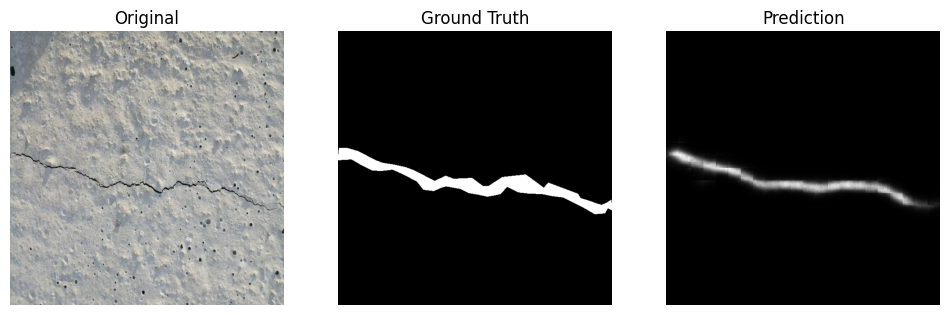

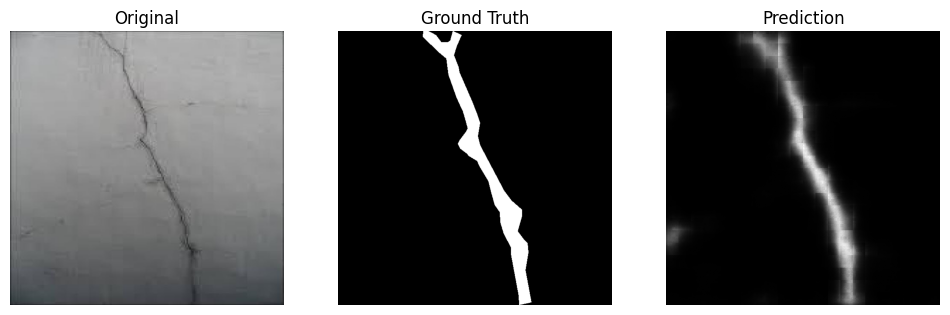

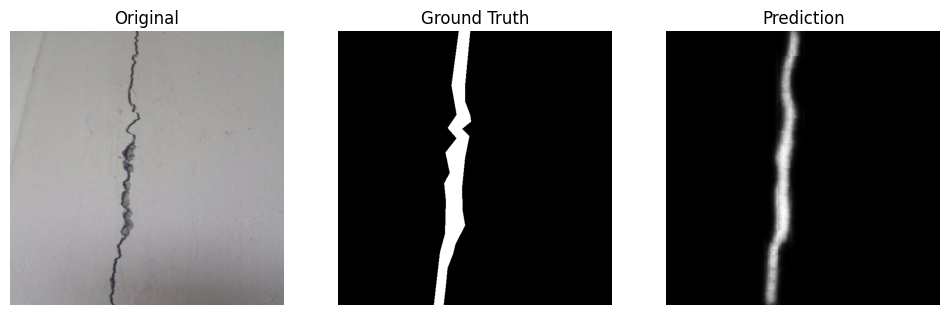

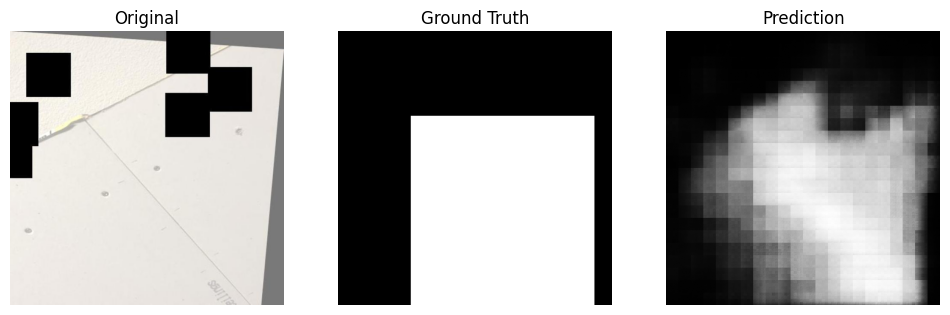

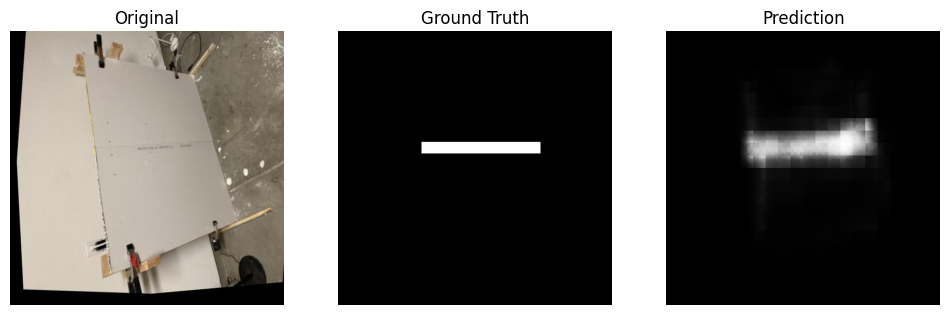

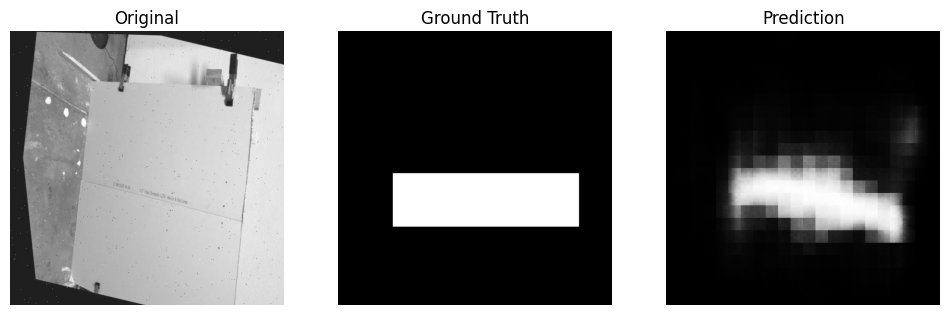

In [18]:
visualize_predictions(crack_model, processor, 
                      "cracks.v1i.coco/valid", 
                      "cracks.v1i.coco/valid/masks", 
                      "segment_crack")

visualize_predictions(dry_model, processor, 
                      "Drywall-Join-Detect.v2i.coco/valid", 
                      "Drywall-Join-Detect.v2i.coco/valid/masks", 
                      "segment_taping_area")


In [20]:
import os
size_mb = os.path.getsize("clipseg_crack_1.pt") / 1e6
print(f"Model size: {size_mb:.2f} MB")


Model size: 603.18 MB


In [17]:
import os
print(os.listdir("cracks.v1i.coco/valid/masks")[:10])


['1045-dat_png_jpg.rf.84d88c594248607d58900ebe76d34b46__segment_crack.png', '1059-dat_png_jpg.rf.ca4329d6ce9f7d86eacc7afc9f5c7149__segment_crack.png', '1083-dat_png_jpg.rf.cf67d74173369d5c02c03d03d67ae6e0__segment_crack.png', '1118-dat_png_jpg.rf.97f4dc78e07717e10a0ee033a23574f6__segment_crack.png', '1120-dat_png_jpg.rf.27ad23af6b6e32ad7bc72a28aba0b32a__segment_crack.png', '1998_jpg.rf.8c495e64a67a591163a0fd38b82c7acc__segment_crack.png', '2110_jpg.rf.04fc462e2feeaa0e37ccc9fc41461443__segment_crack.png', '2111_jpg.rf.f0d79a0d2578a417e84d5a0d7dae1999__segment_crack.png', '2120_jpg.rf.5d03d9ee119f4b0c1b57f740b883dc39__segment_crack.png', '2127_jpg.rf.ecce16e90e67649a3ce506c1269c12ea__segment_crack.png']


In [24]:
print("inputs.pixel_values.shape:", inputs.pixel_values.shape)
print("masks.shape:", masks.shape)


inputs.pixel_values.shape: torch.Size([2, 3, 352, 352])
masks.shape: torch.Size([2, 1, 1, 512, 512])


In [33]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.8.0+cpu
CUDA available: False


In [31]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     ----------------- ---------------------- 1.8/4.1 MB 9.1 MB/s eta 0:00:01
     -------------------------------------- - 3.9/4.1 MB 9.0 MB/s eta 0:00:01
     ---------------------------------------- 4.1/4.1 MB 8.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     --------------- ------------------------ 1.6/4.1 MB 7.6 MB/s eta 0:00:01
     ----------------------------------- ---- 3.7/4.1 MB 9.5 MB/s eta 0:00:01
     ---------------------------------------- 4.1/4.1 MB 8.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.1 MB ? eta -:--:--
     -------------------- ------------------- 2.1/4.1 MB 9.8 MB/s eta 0:00:01
     ------------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")


Torch version: 2.5.1+cu121
CUDA available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [35]:
!nvidia-smi


Sun Oct  5 14:40:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.83                 Driver Version: 576.83         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8             11W /  125W |     170MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
pip uninstall -y torch torchvision torchaudio


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (2449.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)

   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   ---------------------------------------- 0/3 [torch]
   -----------------------------------